In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
import molvs
from multiprocessing import Pool, cpu_count
from tqdm.auto import tqdm

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/7wf5/p2m
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/7wf5


Reading data from crossdock dataset, add a standardization for small molecule data:

In [3]:
standardizer = molvs.standardize.Standardizer()

def standardize_mol(mol):
    try:
        mol = standardizer.standardize(mol)
        mol = standardizer.fragment_parent(mol, skip_standardize=True)
        mol = standardizer.tautomer_parent(mol, skip_standardize=True)
        mol = standardizer.isotope_parent(mol, skip_standardize=True)
        mol = standardizer.charge_parent(mol, skip_standardize=True)
        return mol
    except:
        return None

In [4]:
smi_list = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/7wf5/p2m/500_generated.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in tqdm(smi_list, desc="Standardizing molecules", unit="mol"):
    mol = Chem.MolFromSmiles(smi)
    mol = standardize_mol(mol)
    
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))
    else:
        print(f"Skipping molecule {smi}")
        pass

print(len(smi_list))
len(standardized_smiles_list)

Standardizing molecules:   0%|          | 0/522 [00:00<?, ?mol/s]

522


522

Set the default image size

In [5]:
with open('500_generated_standardized.smi', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

In [6]:
uru.rd_set_image_size(300,300)

Convert SMILES and name of them to a dataframe

In [7]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,CCc1cccnc1
1,CCc1ccccc1N
2,CCc1cccc(F)c1
3,CCc1cncc(C)c1
4,CCc1cccc(F)c1C
...,...
517,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...
518,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...
519,Cc1cn(CCNC2CCCC2)c(-c2ccc(-n3cc(C(O)C(F)(F)F)c...
520,CCCNC(=O)C1C(=Nc2ccc3cncc(Cc4ccccc4)c3c2)C(CNN...


Remove repeated molecules

In [8]:
df = df.drop_duplicates(['SMILES'])
df.reset_index(inplace=True, drop=True)
df

,SMILES
0,CCc1cccnc1
1,CCc1ccccc1N
2,CCc1cccc(F)c1
3,CCc1cncc(C)c1
4,CCc1cccc(F)c1C
...,...
516,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...
517,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...
518,Cc1cn(CCNC2CCCC2)c(-c2ccc(-n3cc(C(O)C(F)(F)F)c...
519,CCCNC(=O)C1C(=Nc2ccc3cncc(Cc4ccccc4)c3c2)C(CNN...


Save the smi file for further use

Add an RDKit molecule to the dataframe

In [9]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

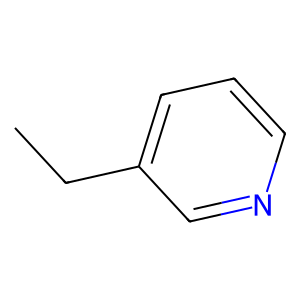

In [10]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [11]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0                                             [c1ccncc1]
1                                             [c1ccccc1]
2                                             [c1ccccc1]
3                                             [c1ccncc1]
4                                             [c1ccccc1]
                             ...                        
516    [c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...
517    [c1cn[nH]c1, c1ccccc1, c1ccccc1, c1c[nH]cn1, c...
518    [c1c[nH]cn1, C1CCCC1, c1ccccc1, c1cn[nH]c1, c1...
519    [N=C1Cc2ccccc2C1, c1ccc2cnccc2c1, c1ccccc1, c1...
520    [c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, C=C1C...
Name: ring_sytems, Length: 521, dtype: object

In [12]:
df.ring_sytems.values

array([list(['c1ccncc1']), list(['c1ccccc1']), list(['c1ccccc1']),
       list(['c1ccncc1']), list(['c1ccccc1']), list(['c1ccc2cnccc2c1']),
       list(['N=c1cc[nH]c2sccc12']), list(['c1ccccc1']),
       list(['c1ccccc1']), list(['c1ccccc1']), list(['c1ccc2ccccc2c1']),
       list(['c1ccncc1']), list(['c1cnc2ccncc2c1']),
       list(['c1ccc2ccccc2c1']), list(['C1CCC2CCCCC2C1']),
       list(['N=c1cc[nH]c2ccccc12']), list(['C=C1C=CC=N1', 'c1nnn[nH]1']),
       list(['c1ccncc1', 'c1nnn[nH]1']), list(['N=c1cc2ccccc2c[nH]1']),
       list(['c1ccc2ccccc2c1']), list(['C1=CC2N=CC=C2N=C1']),
       list(['c1ccncc1', 'c1nnc[nH]1']), list(['N=c1nc2ccccc2c[nH]1']),
       list(['c1ccccc1']), list(['c1ccc2ccccc2c1']),
       list(['C1=CCC2CCOCCC2C1']), list(['c1ccc2nnccc2c1']),
       list(['c1ccc2ncccc2c1']), list(['c1ccccc1', 'c1ncnnn1']),
       list(['O=C1N=Nc2ccccc21']), list(['N=c1[nH]c(=N)c2ccccc2[nH]1']),
       list(['c1ccc2cnccc2c1']), list(['C=c1nccc2c1=NC=CC2']),
       list(['c1ccccc1

See how many times each ring system occurs

In [13]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
1,c1ccccc1,688
0,c1ccncc1,122
43,c1c[nH]cn1,95
4,c1ccc2ccccc2c1,91
29,c1cn[nH]c1,57
...,...,...
21,O=c1[nH]ccc2ccccc12,1
23,C1CCC2CCOCCC2C1,1
96,N=c1ccc2ccccc2[nH]1,1
99,C1COCOC1,1


View the ring system frequencies

In [14]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [15]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

In [16]:
res

0                                   [(c1ccncc1, 275595)]
1                                  [(c1ccccc1, 2568039)]
2                                  [(c1ccccc1, 2568039)]
3                                   [(c1ccncc1, 275595)]
4                                  [(c1ccccc1, 2568039)]
                             ...                        
516    [(c1ccccc1, 2568039), (c1ccccc1, 2568039), (c1...
517    [(c1cn[nH]c1, 112133), (c1ccccc1, 2568039), (c...
518    [(c1c[nH]cn1, 78586), (C1CCCC1, 38317), (c1ccc...
519    [(N=C1Cc2ccccc2C1, 3), (c1ccc2cnccc2c1, 7830),...
520    [(c1ccccc1, 2568039), (c1ccccc1, 2568039), (c1...
Name: mol, Length: 521, dtype: object

In [17]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,CCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd285f0>,[c1ccncc1],c1ccncc1,275595
1,CCc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x79cadbd283c0>,[c1ccccc1],c1ccccc1,2568039
2,CCc1cccc(F)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28510>,[c1ccccc1],c1ccccc1,2568039
3,CCc1cncc(C)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28430>,[c1ccncc1],c1ccncc1,275595
4,CCc1cccc(F)c1C,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28200>,[c1ccccc1],c1ccccc1,2568039
...,...,...,...,...,...
516,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ad000>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1cncnc1,100599
517,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac890>,"[c1cn[nH]c1, c1ccccc1, c1ccccc1, c1c[nH]cn1, c...",c1c[nH]cn1,78586
518,Cc1cn(CCNC2CCCC2)c(-c2ccc(-n3cc(C(O)C(F)(F)F)c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac740>,"[c1c[nH]cn1, C1CCCC1, c1ccccc1, c1cn[nH]c1, c1...",C1CCCC1,38317
519,CCCNC(=O)C1C(=Nc2ccc3cncc(Cc4ccccc4)c3c2)C(CNN...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0acc10>,"[N=C1Cc2ccccc2C1, c1ccc2cnccc2c1, c1ccccc1, c1...",N=C1Cc2ccccc2C1,3


In [18]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [19]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[16:06:21] WARNING: Charges were rearranged

[16:06:21] WARNING: Omitted undefined stereo

[16:06:21] WARNING: Omitted undefined stereo

[16:06:21] WARNING: Omitted undefined stereo

[16:06:21] WARNING: Omitted undefined stereo

[16:06:21] WARNING: Omitted undefined stereo

[16:06:21] WARNING: Omitted undefined stereo

[16:06:22] WARNING: Omitted undefined stereo

[16:06:22] WARNING: Omitted undefined stereo

[16:06:22] WARNING: Omitted undefined stereo

[16:06:22] WARNING: Omitted undefined stereo

[16:06:22] WARNING: Omitted undefined stereo

[16:06:22] WARNING: Omitted undefined stereo

[16:06:22] WARNING: Omitted undefined stereo

[16:06:22] WARNING: Omitted undefined stereo

[16:06:22] WARNING: Omitted undefined stereo

[16:06:22] WARNING: Omitted undefined stereo

[16:06:22] WARNING: Omitted undefined stereo

[16:06:22] WARNING: Omitted undefined stereo

[16:06:22] WARNING: Omitted undefined stereo

[16:06:22] WARNING: Omitted undefined stereo

[16:06:22] WARNING: Omitted undefin

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd285f0>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C7H9N/c1-2-7-4-3-5-8-6-7/h3-6H,2H2,1H3"
1,CCc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x79cadbd283c0>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H11N/c1-2-7-5-3-4-6-8(7)9/h3-6H,2,9..."
2,CCc1cccc(F)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28510>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H9F/c1-2-7-4-3-5-8(9)6-7/h3-6H,2H2,1H3"
3,CCc1cncc(C)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28430>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C8H11N/c1-3-8-4-7(2)5-9-6-8/h4-6H,3H2..."
4,CCc1cccc(F)c1C,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28200>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C9H11F/c1-3-8-5-4-6-9(10)7(8)2/h4-6H,..."
...,...,...,...,...,...,...
516,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ad000>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1cncnc1,100599,InChI=1S/C39H36N4/c1-29-10-6-7-17-37(29)33-14-...
517,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac890>,"[c1cn[nH]c1, c1ccccc1, c1ccccc1, c1c[nH]cn1, c...",c1c[nH]cn1,78586,InChI=1S/C35H34FN5O2/c1-2-3-4-5-6-8-29-22-41(3...
518,Cc1cn(CCNC2CCCC2)c(-c2ccc(-n3cc(C(O)C(F)(F)F)c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac740>,"[c1c[nH]cn1, C1CCCC1, c1ccccc1, c1cn[nH]c1, c1...",C1CCCC1,38317,InChI=1S/C31H31F4N7O/c1-20-16-40(14-13-36-23-6...
519,CCCNC(=O)C1C(=Nc2ccc3cncc(Cc4ccccc4)c3c2)C(CNN...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0acc10>,"[N=C1Cc2ccccc2C1, c1ccc2cnccc2c1, c1ccccc1, c1...",N=C1Cc2ccccc2C1,3,InChI=1S/C36H34N6O/c1-2-16-39-36(43)34-31-13-7...


How many of them have ring system?

In [20]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd285f0>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C7H9N/c1-2-7-4-3-5-8-6-7/h3-6H,2H2,1H3"
1,CCc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x79cadbd283c0>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H11N/c1-2-7-5-3-4-6-8(7)9/h3-6H,2,9..."
2,CCc1cccc(F)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28510>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H9F/c1-2-7-4-3-5-8(9)6-7/h3-6H,2H2,1H3"
3,CCc1cncc(C)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28430>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C8H11N/c1-3-8-4-7(2)5-9-6-8/h4-6H,3H2..."
4,CCc1cccc(F)c1C,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28200>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C9H11F/c1-3-8-5-4-6-9(10)7(8)2/h4-6H,..."
...,...,...,...,...,...,...
516,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ad000>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1cncnc1,100599,InChI=1S/C39H36N4/c1-29-10-6-7-17-37(29)33-14-...
517,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac890>,"[c1cn[nH]c1, c1ccccc1, c1ccccc1, c1c[nH]cn1, c...",c1c[nH]cn1,78586,InChI=1S/C35H34FN5O2/c1-2-3-4-5-6-8-29-22-41(3...
518,Cc1cn(CCNC2CCCC2)c(-c2ccc(-n3cc(C(O)C(F)(F)F)c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac740>,"[c1c[nH]cn1, C1CCCC1, c1ccccc1, c1cn[nH]c1, c1...",C1CCCC1,38317,InChI=1S/C31H31F4N7O/c1-20-16-40(14-13-36-23-6...
519,CCCNC(=O)C1C(=Nc2ccc3cncc(Cc4ccccc4)c3c2)C(CNN...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0acc10>,"[N=C1Cc2ccccc2C1, c1ccc2cnccc2c1, c1ccccc1, c1...",N=C1Cc2ccccc2C1,3,InChI=1S/C36H34N6O/c1-2-16-39-36(43)34-31-13-7...


In [21]:
filtered_df_ring_freq = df[df.min_freq > 100]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd285f0>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C7H9N/c1-2-7-4-3-5-8-6-7/h3-6H,2H2,1H3"
1,CCc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x79cadbd283c0>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H11N/c1-2-7-5-3-4-6-8(7)9/h3-6H,2,9..."
2,CCc1cccc(F)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28510>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H9F/c1-2-7-4-3-5-8(9)6-7/h3-6H,2H2,1H3"
3,CCc1cncc(C)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28430>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C8H11N/c1-3-8-4-7(2)5-9-6-8/h4-6H,3H2..."
4,CCc1cccc(F)c1C,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28200>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C9H11F/c1-3-8-5-4-6-9(10)7(8)2/h4-6H,..."
...,...,...,...,...,...,...
511,OCC1COC(Cn2ccnc2-c2ccc(-n3cc(C(O)C(F)(F)F)c(-c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ad310>,"[C1COCCN1, c1c[nH]cn1, c1ccccc1, c1cn[nH]c1, c...",c1c[nH]cn1,78586,InChI=1S/C29H27F4N7O3/c30-19-2-1-3-22(10-19)39...
514,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCNC(=O)Cc4c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac120>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1ccc2ccccc2c1,55872,InChI=1S/C38H34N4O/c1-27-8-2-5-15-35(27)32-12-...
516,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ad000>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1cncnc1,100599,InChI=1S/C39H36N4/c1-29-10-6-7-17-37(29)33-14-...
517,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac890>,"[c1cn[nH]c1, c1ccccc1, c1ccccc1, c1c[nH]cn1, c...",c1c[nH]cn1,78586,InChI=1S/C35H34FN5O2/c1-2-3-4-5-6-8-29-22-41(3...


### How many of them could pass PAINS filter?

Get a list of rules

In [22]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [23]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [24]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [25]:
reos.pandas_mols(df.mol)

  0%|          | 0/521 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,ok,ok
4,ok,ok
...,...,...
516,ok,ok
517,ok,ok
518,ok,ok
519,ok,ok


In [26]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/521 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,CCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd285f0>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C7H9N/c1-2-7-4-3-5-8-6-7/h3-6H,2H2,1H3",ok,ok
1,CCc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x79cadbd283c0>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H11N/c1-2-7-5-3-4-6-8(7)9/h3-6H,2,9...",ok,ok
2,CCc1cccc(F)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28510>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H9F/c1-2-7-4-3-5-8(9)6-7/h3-6H,2H2,1H3",ok,ok
3,CCc1cncc(C)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28430>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C8H11N/c1-3-8-4-7(2)5-9-6-8/h4-6H,3H2...",ok,ok
4,CCc1cccc(F)c1C,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28200>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C9H11F/c1-3-8-5-4-6-9(10)7(8)2/h4-6H,...",ok,ok
...,...,...,...,...,...,...,...,...
516,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ad000>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1cncnc1,100599,InChI=1S/C39H36N4/c1-29-10-6-7-17-37(29)33-14-...,ok,ok
517,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac890>,"[c1cn[nH]c1, c1ccccc1, c1ccccc1, c1c[nH]cn1, c...",c1c[nH]cn1,78586,InChI=1S/C35H34FN5O2/c1-2-3-4-5-6-8-29-22-41(3...,ok,ok
518,Cc1cn(CCNC2CCCC2)c(-c2ccc(-n3cc(C(O)C(F)(F)F)c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac740>,"[c1c[nH]cn1, C1CCCC1, c1ccccc1, c1cn[nH]c1, c1...",C1CCCC1,38317,InChI=1S/C31H31F4N7O/c1-20-16-40(14-13-36-23-6...,ok,ok
519,CCCNC(=O)C1C(=Nc2ccc3cncc(Cc4ccccc4)c3c2)C(CNN...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0acc10>,"[N=C1Cc2ccccc2C1, c1ccc2cnccc2c1, c1ccccc1, c1...",N=C1Cc2ccccc2C1,3,InChI=1S/C36H34N6O/c1-2-16-39-36(43)34-31-13-7...,ok,ok


Test all filters from rd filters

In [27]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/521 [00:00<?, ?it/s]

Glaxo 0.963531669865643 ['Glaxo'] 502


  0%|          | 0/521 [00:00<?, ?it/s]

Dundee 0.54510556621881 ['Dundee'] 284


  0%|          | 0/521 [00:00<?, ?it/s]

BMS 0.9289827255278311 ['BMS'] 484


  0%|          | 0/521 [00:00<?, ?it/s]

SureChEMBL 0.7984644913627639 ['SureChEMBL'] 416


  0%|          | 0/521 [00:00<?, ?it/s]

MLSMR 0.5393474088291746 ['MLSMR'] 281


  0%|          | 0/521 [00:00<?, ?it/s]

Inpharmatica 0.9232245681381958 ['Inpharmatica'] 481


  0%|          | 0/521 [00:00<?, ?it/s]

LINT 0.6391554702495201 ['LINT'] 333


### How many of them could pass filters suggested by Dr.Reymond?

In [28]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd285f0>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C7H9N/c1-2-7-4-3-5-8-6-7/h3-6H,2H2,1H3",True
1,CCc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x79cadbd283c0>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H11N/c1-2-7-5-3-4-6-8(7)9/h3-6H,2,9...",True
2,CCc1cccc(F)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28510>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H9F/c1-2-7-4-3-5-8(9)6-7/h3-6H,2H2,1H3",True
3,CCc1cncc(C)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28430>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C8H11N/c1-3-8-4-7(2)5-9-6-8/h4-6H,3H2...",True
4,CCc1cccc(F)c1C,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28200>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C9H11F/c1-3-8-5-4-6-9(10)7(8)2/h4-6H,...",True
...,...,...,...,...,...,...,...
516,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ad000>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1cncnc1,100599,InChI=1S/C39H36N4/c1-29-10-6-7-17-37(29)33-14-...,True
517,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac890>,"[c1cn[nH]c1, c1ccccc1, c1ccccc1, c1c[nH]cn1, c...",c1c[nH]cn1,78586,InChI=1S/C35H34FN5O2/c1-2-3-4-5-6-8-29-22-41(3...,True
518,Cc1cn(CCNC2CCCC2)c(-c2ccc(-n3cc(C(O)C(F)(F)F)c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac740>,"[c1c[nH]cn1, C1CCCC1, c1ccccc1, c1cn[nH]c1, c1...",C1CCCC1,38317,InChI=1S/C31H31F4N7O/c1-20-16-40(14-13-36-23-6...,True
519,CCCNC(=O)C1C(=Nc2ccc3cncc(Cc4ccccc4)c3c2)C(CNN...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0acc10>,"[N=C1Cc2ccccc2C1, c1ccc2cnccc2c1, c1ccccc1, c1...",N=C1Cc2ccccc2C1,3,InChI=1S/C36H34N6O/c1-2-16-39-36(43)34-31-13-7...,True


In [29]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd285f0>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C7H9N/c1-2-7-4-3-5-8-6-7/h3-6H,2H2,1H3",True
1,CCc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x79cadbd283c0>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H11N/c1-2-7-5-3-4-6-8(7)9/h3-6H,2,9...",True
2,CCc1cccc(F)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28510>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H9F/c1-2-7-4-3-5-8(9)6-7/h3-6H,2H2,1H3",True
3,CCc1cncc(C)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28430>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C8H11N/c1-3-8-4-7(2)5-9-6-8/h4-6H,3H2...",True
4,CCc1cccc(F)c1C,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28200>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C9H11F/c1-3-8-5-4-6-9(10)7(8)2/h4-6H,...",True
...,...,...,...,...,...,...,...
516,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ad000>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1cncnc1,100599,InChI=1S/C39H36N4/c1-29-10-6-7-17-37(29)33-14-...,True
517,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac890>,"[c1cn[nH]c1, c1ccccc1, c1ccccc1, c1c[nH]cn1, c...",c1c[nH]cn1,78586,InChI=1S/C35H34FN5O2/c1-2-3-4-5-6-8-29-22-41(3...,True
518,Cc1cn(CCNC2CCCC2)c(-c2ccc(-n3cc(C(O)C(F)(F)F)c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac740>,"[c1c[nH]cn1, C1CCCC1, c1ccccc1, c1cn[nH]c1, c1...",C1CCCC1,38317,InChI=1S/C31H31F4N7O/c1-20-16-40(14-13-36-23-6...,True
519,CCCNC(=O)C1C(=Nc2ccc3cncc(Cc4ccccc4)c3c2)C(CNN...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0acc10>,"[N=C1Cc2ccccc2C1, c1ccc2cnccc2c1, c1ccccc1, c1...",N=C1Cc2ccccc2C1,3,InChI=1S/C36H34N6O/c1-2-16-39-36(43)34-31-13-7...,True


### How many of them could pass RO5?

In [31]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd285f0>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C7H9N/c1-2-7-4-3-5-8-6-7/h3-6H,2H2,1H3",True,True
1,CCc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x79cadbd283c0>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H11N/c1-2-7-5-3-4-6-8(7)9/h3-6H,2,9...",True,True
2,CCc1cccc(F)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28510>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H9F/c1-2-7-4-3-5-8(9)6-7/h3-6H,2H2,1H3",True,True
3,CCc1cncc(C)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28430>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C8H11N/c1-3-8-4-7(2)5-9-6-8/h4-6H,3H2...",True,True
4,CCc1cccc(F)c1C,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28200>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C9H11F/c1-3-8-5-4-6-9(10)7(8)2/h4-6H,...",True,True
...,...,...,...,...,...,...,...,...
516,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ad000>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1cncnc1,100599,InChI=1S/C39H36N4/c1-29-10-6-7-17-37(29)33-14-...,True,False
517,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac890>,"[c1cn[nH]c1, c1ccccc1, c1ccccc1, c1c[nH]cn1, c...",c1c[nH]cn1,78586,InChI=1S/C35H34FN5O2/c1-2-3-4-5-6-8-29-22-41(3...,True,False
518,Cc1cn(CCNC2CCCC2)c(-c2ccc(-n3cc(C(O)C(F)(F)F)c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac740>,"[c1c[nH]cn1, C1CCCC1, c1ccccc1, c1cn[nH]c1, c1...",C1CCCC1,38317,InChI=1S/C31H31F4N7O/c1-20-16-40(14-13-36-23-6...,True,False
519,CCCNC(=O)C1C(=Nc2ccc3cncc(Cc4ccccc4)c3c2)C(CNN...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0acc10>,"[N=C1Cc2ccccc2C1, c1ccc2cnccc2c1, c1ccccc1, c1...",N=C1Cc2ccccc2C1,3,InChI=1S/C36H34N6O/c1-2-16-39-36(43)34-31-13-7...,True,False


In [32]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd285f0>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C7H9N/c1-2-7-4-3-5-8-6-7/h3-6H,2H2,1H3",True,True
1,CCc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x79cadbd283c0>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H11N/c1-2-7-5-3-4-6-8(7)9/h3-6H,2,9...",True,True
2,CCc1cccc(F)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28510>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C8H9F/c1-2-7-4-3-5-8(9)6-7/h3-6H,2H2,1H3",True,True
3,CCc1cncc(C)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28430>,[c1ccncc1],c1ccncc1,275595,"InChI=1S/C8H11N/c1-3-8-4-7(2)5-9-6-8/h4-6H,3H2...",True,True
4,CCc1cccc(F)c1C,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28200>,[c1ccccc1],c1ccccc1,2568039,"InChI=1S/C9H11F/c1-3-8-5-4-6-9(10)7(8)2/h4-6H,...",True,True
...,...,...,...,...,...,...,...,...
332,O=c1ccccn1-c1cc(CCO)cc(C2CC(c3cn(-c4ccccc4)cn3...,<rdkit.Chem.rdchem.Mol object at 0x79cadbd787b0>,"[O=c1cccc[nH]1, c1ccccc1, C1CCN2CCCC2C1, c1c[n...",C1CCN2CCCC2C1,77,InChI=1S/C30H31FN4O2/c31-30-24(16-21(12-15-36)...,True,True
336,Cc1ccccc1CCC(=O)Cc1cc(C)c(CC(N)=O)nc1-c1ccc(-c...,<rdkit.Chem.rdchem.Mol object at 0x79cadbd7b220>,"[c1ccccc1, c1ccncc1, c1ccccc1, c1nc[nH]n1]",c1nc[nH]n1,43596,InChI=1S/C29H31N5O3/c1-18-5-3-4-6-20(18)11-12-...,True,True
340,O=c1ccccn1-c1cc(CCO)cc(C2CC(c3cn(-c4ccccc4)cn3...,<rdkit.Chem.rdchem.Mol object at 0x79cadbd79bd0>,"[O=c1cccc[nH]1, c1ccccc1, C1CCN2CCCC2C1, c1c[n...",C1CCN2CCCC2C1,77,InChI=1S/C30H32N4O3/c35-15-12-21-16-24(30(37)2...,True,True
344,Cc1cccc2c1=C(c1ncn(-c3ccc(F)cc3)n1)CC=2c1ccc(C...,<rdkit.Chem.rdchem.Mol object at 0x79cadbd794d0>,"[C1=c2ccccc2=CC1, c1nc[nH]n1, c1ccccc1, c1ccccc1]",C1=c2ccccc2=CC1,0,InChI=1S/C30H30FN5O/c1-20-6-5-7-25-26(21-8-10-...,True,True


### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [33]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0                               [(c1ccncc1, 9975620076)]
1                              [(c1ccccc1, 21243538754)]
2                              [(c1ccccc1, 21243538754)]
3                               [(c1ccncc1, 9975620076)]
4                              [(c1ccccc1, 21243538754)]
                             ...                        
516    [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
517    [(c1cn[nH]c1, 8081544476), (c1ccccc1, 21243538...
518    [(c1c[nH]cn1, 2706690320), (C1CCCC1, 531721769...
519    [(N=C1Cc2ccccc2C1, 296), (c1ccc2cnccc2c1, 1382...
520    [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
Name: mol, Length: 521, dtype: object

In [34]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd285f0>,[c1ccncc1],c1ccncc1,9975620076,"InChI=1S/C7H9N/c1-2-7-4-3-5-8-6-7/h3-6H,2H2,1H3",True,True
1,CCc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x79cadbd283c0>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C8H11N/c1-2-7-5-3-4-6-8(7)9/h3-6H,2,9...",True,True
2,CCc1cccc(F)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28510>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C8H9F/c1-2-7-4-3-5-8(9)6-7/h3-6H,2H2,1H3",True,True
3,CCc1cncc(C)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28430>,[c1ccncc1],c1ccncc1,9975620076,"InChI=1S/C8H11N/c1-3-8-4-7(2)5-9-6-8/h4-6H,3H2...",True,True
4,CCc1cccc(F)c1C,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28200>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C9H11F/c1-3-8-5-4-6-9(10)7(8)2/h4-6H,...",True,True
...,...,...,...,...,...,...,...,...
516,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ad000>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1cncnc1,2861731550,InChI=1S/C39H36N4/c1-29-10-6-7-17-37(29)33-14-...,True,False
517,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac890>,"[c1cn[nH]c1, c1ccccc1, c1ccccc1, c1c[nH]cn1, c...",c1c[nH]cn1,2706690320,InChI=1S/C35H34FN5O2/c1-2-3-4-5-6-8-29-22-41(3...,True,False
518,Cc1cn(CCNC2CCCC2)c(-c2ccc(-n3cc(C(O)C(F)(F)F)c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac740>,"[c1c[nH]cn1, C1CCCC1, c1ccccc1, c1cn[nH]c1, c1...",c1c[nH]cn1,2706690320,InChI=1S/C31H31F4N7O/c1-20-16-40(14-13-36-23-6...,True,False
519,CCCNC(=O)C1C(=Nc2ccc3cncc(Cc4ccccc4)c3c2)C(CNN...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0acc10>,"[N=C1Cc2ccccc2C1, c1ccc2cnccc2c1, c1ccccc1, c1...",N=C1Cc2ccccc2C1,296,InChI=1S/C36H34N6O/c1-2-16-39-36(43)34-31-13-7...,True,False


In [35]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [36]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd285f0>,[c1ccncc1],c1ccncc1,9975620076,"InChI=1S/C7H9N/c1-2-7-4-3-5-8-6-7/h3-6H,2H2,1H3",True,True
1,CCc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x79cadbd283c0>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C8H11N/c1-2-7-5-3-4-6-8(7)9/h3-6H,2,9...",True,True
2,CCc1cccc(F)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28510>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C8H9F/c1-2-7-4-3-5-8(9)6-7/h3-6H,2H2,1H3",True,True
3,CCc1cncc(C)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28430>,[c1ccncc1],c1ccncc1,9975620076,"InChI=1S/C8H11N/c1-3-8-4-7(2)5-9-6-8/h4-6H,3H2...",True,True
4,CCc1cccc(F)c1C,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28200>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C9H11F/c1-3-8-5-4-6-9(10)7(8)2/h4-6H,...",True,True
...,...,...,...,...,...,...,...,...
515,NCCCCNCC(=O)N(CCO)c1cc(CCO)cc(C2CC(c3cn(-c4ccc...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0acf90>,"[c1ccccc1, C1CCN2CCCC2C1, c1c[nH]cn1, c1ccccc1]",C1CCN2CCCC2C1,128926,InChI=1S/C33H46N6O4/c34-12-5-6-13-35-21-32(42)...,True,False
516,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ad000>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1cncnc1,2861731550,InChI=1S/C39H36N4/c1-29-10-6-7-17-37(29)33-14-...,True,False
517,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac890>,"[c1cn[nH]c1, c1ccccc1, c1ccccc1, c1c[nH]cn1, c...",c1c[nH]cn1,2706690320,InChI=1S/C35H34FN5O2/c1-2-3-4-5-6-8-29-22-41(3...,True,False
518,Cc1cn(CCNC2CCCC2)c(-c2ccc(-n3cc(C(O)C(F)(F)F)c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac740>,"[c1c[nH]cn1, C1CCCC1, c1ccccc1, c1cn[nH]c1, c1...",c1c[nH]cn1,2706690320,InChI=1S/C31H31F4N7O/c1-20-16-40(14-13-36-23-6...,True,False


In [37]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd285f0>,[c1ccncc1],c1ccncc1,9975620076,"InChI=1S/C7H9N/c1-2-7-4-3-5-8-6-7/h3-6H,2H2,1H3",True,True
1,CCc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x79cadbd283c0>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C8H11N/c1-2-7-5-3-4-6-8(7)9/h3-6H,2,9...",True,True
2,CCc1cccc(F)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28510>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C8H9F/c1-2-7-4-3-5-8(9)6-7/h3-6H,2H2,1H3",True,True
3,CCc1cncc(C)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28430>,[c1ccncc1],c1ccncc1,9975620076,"InChI=1S/C8H11N/c1-3-8-4-7(2)5-9-6-8/h4-6H,3H2...",True,True
4,CCc1cccc(F)c1C,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28200>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C9H11F/c1-3-8-5-4-6-9(10)7(8)2/h4-6H,...",True,True
...,...,...,...,...,...,...,...,...
516,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ad000>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1cncnc1,2861731550,InChI=1S/C39H36N4/c1-29-10-6-7-17-37(29)33-14-...,True,False
517,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac890>,"[c1cn[nH]c1, c1ccccc1, c1ccccc1, c1c[nH]cn1, c...",c1c[nH]cn1,2706690320,InChI=1S/C35H34FN5O2/c1-2-3-4-5-6-8-29-22-41(3...,True,False
518,Cc1cn(CCNC2CCCC2)c(-c2ccc(-n3cc(C(O)C(F)(F)F)c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac740>,"[c1c[nH]cn1, C1CCCC1, c1ccccc1, c1cn[nH]c1, c1...",c1c[nH]cn1,2706690320,InChI=1S/C31H31F4N7O/c1-20-16-40(14-13-36-23-6...,True,False
519,CCCNC(=O)C1C(=Nc2ccc3cncc(Cc4ccccc4)c3c2)C(CNN...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0acc10>,"[N=C1Cc2ccccc2C1, c1ccc2cnccc2c1, c1ccccc1, c1...",N=C1Cc2ccccc2C1,296,InChI=1S/C36H34N6O/c1-2-16-39-36(43)34-31-13-7...,True,False


In [38]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd285f0>,[c1ccncc1],c1ccncc1,9975620076,"InChI=1S/C7H9N/c1-2-7-4-3-5-8-6-7/h3-6H,2H2,1H3",True,True
1,CCc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x79cadbd283c0>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C8H11N/c1-2-7-5-3-4-6-8(7)9/h3-6H,2,9...",True,True
2,CCc1cccc(F)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28510>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C8H9F/c1-2-7-4-3-5-8(9)6-7/h3-6H,2H2,1H3",True,True
3,CCc1cncc(C)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28430>,[c1ccncc1],c1ccncc1,9975620076,"InChI=1S/C8H11N/c1-3-8-4-7(2)5-9-6-8/h4-6H,3H2...",True,True
4,CCc1cccc(F)c1C,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28200>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C9H11F/c1-3-8-5-4-6-9(10)7(8)2/h4-6H,...",True,True
...,...,...,...,...,...,...,...,...
515,NCCCCNCC(=O)N(CCO)c1cc(CCO)cc(C2CC(c3cn(-c4ccc...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0acf90>,"[c1ccccc1, C1CCN2CCCC2C1, c1c[nH]cn1, c1ccccc1]",C1CCN2CCCC2C1,128926,InChI=1S/C33H46N6O4/c34-12-5-6-13-35-21-32(42)...,True,False
516,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ad000>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1cncnc1,2861731550,InChI=1S/C39H36N4/c1-29-10-6-7-17-37(29)33-14-...,True,False
517,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac890>,"[c1cn[nH]c1, c1ccccc1, c1ccccc1, c1c[nH]cn1, c...",c1c[nH]cn1,2706690320,InChI=1S/C35H34FN5O2/c1-2-3-4-5-6-8-29-22-41(3...,True,False
518,Cc1cn(CCNC2CCCC2)c(-c2ccc(-n3cc(C(O)C(F)(F)F)c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac740>,"[c1c[nH]cn1, C1CCCC1, c1ccccc1, c1cn[nH]c1, c1...",c1c[nH]cn1,2706690320,InChI=1S/C31H31F4N7O/c1-20-16-40(14-13-36-23-6...,True,False


### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [39]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0                                [(c1ccncc1, 110130832)]
1                                [(c1ccccc1, 503413992)]
2                                [(c1ccccc1, 503413992)]
3                                [(c1ccncc1, 110130832)]
4                                [(c1ccccc1, 503413992)]
                             ...                        
516    [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
517    [(c1cn[nH]c1, 94875952), (c1ccccc1, 503413992)...
518    [(c1c[nH]cn1, 26014852), (C1CCCC1, 34084223), ...
519    [(N=C1Cc2ccccc2C1, 348), (c1ccc2cnccc2c1, 1540...
520    [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
Name: mol, Length: 521, dtype: object

In [40]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd285f0>,[c1ccncc1],c1ccncc1,110130832,"InChI=1S/C7H9N/c1-2-7-4-3-5-8-6-7/h3-6H,2H2,1H3",True,True
1,CCc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x79cadbd283c0>,[c1ccccc1],c1ccccc1,503413992,"InChI=1S/C8H11N/c1-2-7-5-3-4-6-8(7)9/h3-6H,2,9...",True,True
2,CCc1cccc(F)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28510>,[c1ccccc1],c1ccccc1,503413992,"InChI=1S/C8H9F/c1-2-7-4-3-5-8(9)6-7/h3-6H,2H2,1H3",True,True
3,CCc1cncc(C)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28430>,[c1ccncc1],c1ccncc1,110130832,"InChI=1S/C8H11N/c1-3-8-4-7(2)5-9-6-8/h4-6H,3H2...",True,True
4,CCc1cccc(F)c1C,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28200>,[c1ccccc1],c1ccccc1,503413992,"InChI=1S/C9H11F/c1-3-8-5-4-6-9(10)7(8)2/h4-6H,...",True,True
...,...,...,...,...,...,...,...,...
516,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ad000>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1cncnc1,30067373,InChI=1S/C39H36N4/c1-29-10-6-7-17-37(29)33-14-...,True,False
517,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac890>,"[c1cn[nH]c1, c1ccccc1, c1ccccc1, c1c[nH]cn1, c...",c1c[nH]cn1,26014852,InChI=1S/C35H34FN5O2/c1-2-3-4-5-6-8-29-22-41(3...,True,False
518,Cc1cn(CCNC2CCCC2)c(-c2ccc(-n3cc(C(O)C(F)(F)F)c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac740>,"[c1c[nH]cn1, C1CCCC1, c1ccccc1, c1cn[nH]c1, c1...",c1c[nH]cn1,26014852,InChI=1S/C31H31F4N7O/c1-20-16-40(14-13-36-23-6...,True,False
519,CCCNC(=O)C1C(=Nc2ccc3cncc(Cc4ccccc4)c3c2)C(CNN...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0acc10>,"[N=C1Cc2ccccc2C1, c1ccc2cnccc2c1, c1ccccc1, c1...",N=C1Cc2ccccc2C1,348,InChI=1S/C36H34N6O/c1-2-16-39-36(43)34-31-13-7...,True,False


In [41]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [42]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCc1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd285f0>,[c1ccncc1],c1ccncc1,110130832,"InChI=1S/C7H9N/c1-2-7-4-3-5-8-6-7/h3-6H,2H2,1H3",True,True
1,CCc1ccccc1N,<rdkit.Chem.rdchem.Mol object at 0x79cadbd283c0>,[c1ccccc1],c1ccccc1,503413992,"InChI=1S/C8H11N/c1-2-7-5-3-4-6-8(7)9/h3-6H,2,9...",True,True
2,CCc1cccc(F)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28510>,[c1ccccc1],c1ccccc1,503413992,"InChI=1S/C8H9F/c1-2-7-4-3-5-8(9)6-7/h3-6H,2H2,1H3",True,True
3,CCc1cncc(C)c1,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28430>,[c1ccncc1],c1ccncc1,110130832,"InChI=1S/C8H11N/c1-3-8-4-7(2)5-9-6-8/h4-6H,3H2...",True,True
4,CCc1cccc(F)c1C,<rdkit.Chem.rdchem.Mol object at 0x79cadbd28200>,[c1ccccc1],c1ccccc1,503413992,"InChI=1S/C9H11F/c1-3-8-5-4-6-9(10)7(8)2/h4-6H,...",True,True
...,...,...,...,...,...,...,...,...
514,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCNC(=O)Cc4c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac120>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1ccc2ccccc2c1,4273930,InChI=1S/C38H34N4O/c1-27-8-2-5-15-35(27)32-12-...,True,False
516,Cc1ccccc1-c1cccc(Cc2nccc(-c3cccc(NCCN(C)c4ccc(...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ad000>,"[c1ccccc1, c1ccccc1, c1cncnc1, c1ccccc1, c1ccc...",c1cncnc1,30067373,InChI=1S/C39H36N4/c1-29-10-6-7-17-37(29)33-14-...,True,False
517,CC=CCCCCc1cn(-c2ccc(C(=O)NCCc3ccc(C=O)cc3)cc2)...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac890>,"[c1cn[nH]c1, c1ccccc1, c1ccccc1, c1c[nH]cn1, c...",c1c[nH]cn1,26014852,InChI=1S/C35H34FN5O2/c1-2-3-4-5-6-8-29-22-41(3...,True,False
518,Cc1cn(CCNC2CCCC2)c(-c2ccc(-n3cc(C(O)C(F)(F)F)c...,<rdkit.Chem.rdchem.Mol object at 0x79cadc0ac740>,"[c1c[nH]cn1, C1CCCC1, c1ccccc1, c1cn[nH]c1, c1...",c1c[nH]cn1,26014852,InChI=1S/C31H31F4N7O/c1-20-16-40(14-13-36-23-6...,True,False
